# RF Signal Integrity to Power Integrity:  Part 8

## Part 8 and 9 Combined Available

This part 8 and next part 9 share the majority of codes, please check [part 9](https://github.com/Qorvo/QSPICE_on_MWJ/tree/main/Article9) too.  
The part9 contains a part 8 and 9 combined notebook.

# Install PyQSPICE First!

In your cmd.exe window.
```
> pip install PyQSPICE
```

## After Python Script

This folder contains resulting files after running the Python Script.
The [**"Sim1"**](https://github.com/Qorvo/QSPICE_on_MWJ/tree/main/Article8/Sim1) folder next to this-folder is "before running script".

# Part 8 Overview

This model is an example of reconstructing the loop transfer function from its "open loop ZOUT (when VRM = OFF)" and "closed loop ZOUT (when VRM = ON)" from the post  
["part8"](https://www.microwavejournal.com/blogs/32-rf-signal-integrity-to-power-integrity/post/41274-reconstructing-a-loop-transfer-function-from-output-impedance-zout) of a series blog/article  
[RF Signal Integrity to Power Integrity](https://www.microwavejournal.com/blogs/32-rf-signal-integrity-to-power-integrity) on  
[Microwave Journal](https://www.microwavejournal.com/).



# Bode-Plot, Nyquist-Diagram, Output-Impedance Open/Closed, Reconstructing Loop from Zout(open/close), NISM

By using an LDO model, we see various ways of loop stability checking methods in one place.
This simulation schematic runs 6 ".AC" steps as shown below.

|              | Bode Plot | Zout(closed)     | Zout(open)       |
|--------------|-----------|------------------|------------------|
| Error Amp 1  | Step = 0  | Step = 2         | Step = 4         |
| Error Amp 2  | Step = 1  | Step = 3         | Step = 5         |

* Simulations for Bode Plots (Step = 0, 1) give us Bode Plots for pairs of (phase margin, gain margin),
  also we can generate Nyquist diagrams.
* Simulations for Output Impedance "Closed Loop" give us Q-Factor shape of the loop,
  and we can get Tg curves.  Then, we can run NISM.
* Simulations for Output Impeance "Open Loop" give us a capability to reconstruct the loop transfer function by comparing with the "Closed Loop" counter part.

> NOTE:  NISM is very accurate with 2nd order system..., this LDO model/DUT is not 2nd order but has more...as I can get nicer looking Nyquist diagrams.

## 1. Run a Simulation

After running below block of code, we have the simulation result in a Pandas DataFrame **df0**.

![](VRM_ZoPart8_sch.png)

In [1]:
from PyQSPICE import clsQSPICE as pqs

import subprocess
import math
import cmath
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from numpy import sin, cos, pi, linspace

fname = "VRM_ZoPart8"

run = pqs(fname)

run.InitPlot()

run.qsch2cir()
run.cir2qraw()

run.setNline(2048)

g = "V(VOUT)/V(VO)"
z = "V(VOUT)"

df0 = run.LoadQRAW([g, z])
print(df0)

               Freq               V(VOUT)/V(VO)             V(VOUT)  Step
0      1.000000e+00 -46857.377758+30464.634818j  0.999985-0.000010j     0
1      1.009035e+00 -46606.098908+30575.157244j  0.999985-0.000010j     0
2      1.018152e+00 -46353.010742+30683.993109j  0.999985-0.000010j     0
3      1.027351e+00 -46098.135037+30791.106635j  0.999985-0.000010j     0
4      1.036633e+00 -45841.494461+30896.462305j  0.999985-0.000010j     0
...             ...                         ...                 ...   ...
12289  9.646616e+07      1.000000+    0.000000j  0.001081+0.133340j     5
12290  9.733774e+07      1.000000+    0.000000j  0.001082+0.134545j     5
12291  9.821719e+07      1.000000+    0.000000j  0.001084+0.135761j     5
12292  9.910459e+07      1.000000+    0.000000j  0.001085+0.136988j     5
12293  1.000000e+08      1.000000+    0.000000j  0.001087+0.138225j     5

[12294 rows x 4 columns]


## 2. Re-arranging DataFrame

The QSPICE returns its result in a "tall format" of 12294 lines/rows.
We re-arrange it into the 2x3 format just like a table at the top of this document.
Then, we calcuate/add gain and phase into the DataFrame.

### 2.1 Reconstructing Loop Transfer Function

Also, we calcuate the loop from Zout(closed) and Zout(open).

In [2]:
df = df0[df0.Step <= 1].reset_index(drop=True)
df = run.GainPhase(df, g, "gain", "phase", "reGain", "imGain", -1)

df["Zout(Closed)"] = df0.query('Step == 2 or Step == 3').reset_index(drop=True).loc[:,"V(VOUT)"]
df["Zout(Open)"] = df0.query('Step == 4 or Step == 5').reset_index(drop=True).loc[:,"V(VOUT)"]

def CalcZ(row):
    row["T"] = 1 - row["Zout(Open)"] / row["Zout(Closed)"]
    return row
df = df.apply(CalcZ, axis=1)

df = run.GainPhase(df, "T", "abs(Tzo)", "arg(Tzo)")
df = run.GainPhase(df, "Zout(Closed)", "abs(Zoc)", "arg(Zoc)")
df = run.GainPhase(df, "Zout(Open)", "abs(Zoo)", "arg(Zoo)")
run.comp2real(df, ["Step", "reGain", "imGain", "gain", "phase", "abs(Tzo)", "arg(Tzo)", "abs(Zoc)", "arg(Zoc)", "abs(Zoo)", "arg(Zoo)", run.sim['Xlbl']])

print(df)

              Freq               V(VOUT)/V(VO)             V(VOUT)  Step  \
0     1.000000e+00 -46857.377758+30464.634818j  0.999985-0.000010j   0.0   
1     1.009035e+00 -46606.098908+30575.157244j  0.999985-0.000010j   0.0   
2     1.018152e+00 -46353.010742+30683.993109j  0.999985-0.000010j   0.0   
3     1.027351e+00 -46098.135037+30791.106635j  0.999985-0.000010j   0.0   
4     1.036633e+00 -45841.494461+30896.462305j  0.999985-0.000010j   0.0   
...            ...                         ...                 ...   ...   
4093  9.646616e+07      0.000000+    0.000011j -0.000000-0.000011j   1.0   
4094  9.733774e+07      0.000000+    0.000011j -0.000000-0.000011j   1.0   
4095  9.821719e+07      0.000000+    0.000011j -0.000000-0.000011j   1.0   
4096  9.910459e+07      0.000000+    0.000011j -0.000000-0.000011j   1.0   
4097  1.000000e+08      0.000000+    0.000011j -0.000000-0.000011j   1.0   

           gain       phase        reGain        imGain        Zout(Closed)  \
0     94

> ***Note*** that the gain calculation of "df = df.apply()" makes everything "complex".  So we re-convert known "non-complex" data to "real".

## 3. Plot All 6 Original Steps

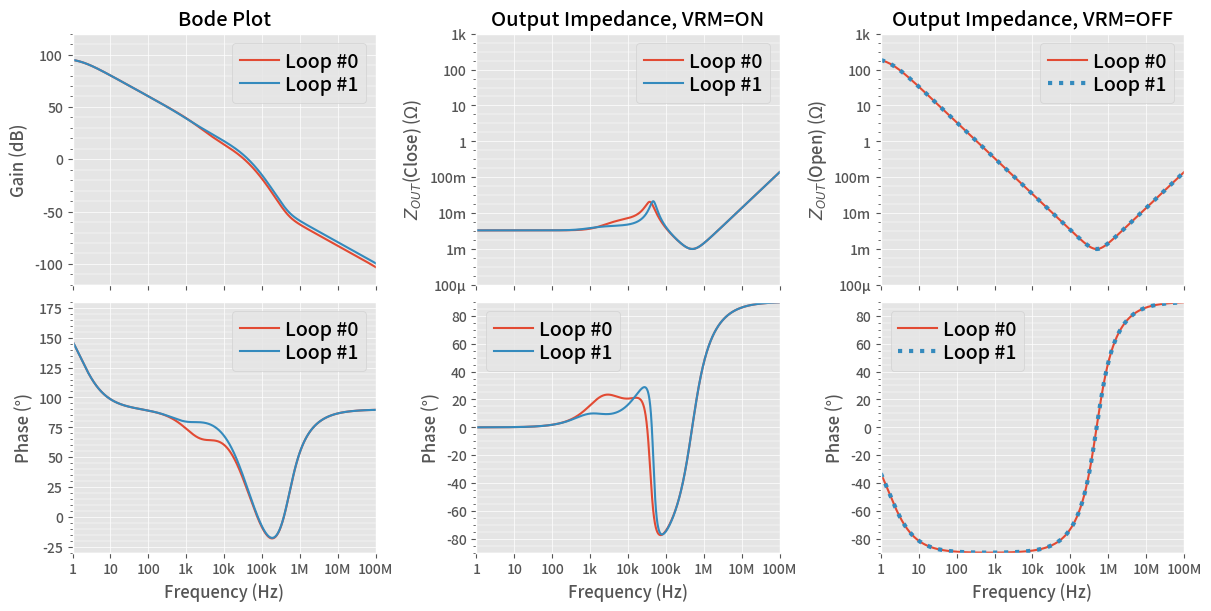

In [3]:
# Prepare a blank plotting area
plt.close('all')
fig, ax = plt.subplots(2,3,sharex=True,constrained_layout=True,figsize=(12,6))

# Bode Plots
# Position: Upper Left [0,0], Gain
df[df.Step == 0].plot(ax=ax[0,0], x="Freq",  y="gain", label="Loop #0")
df[df.Step == 1].plot(ax=ax[0,0], x="Freq",  y="gain", label="Loop #1")
run.PrepFreqGainPlot(ax[0,0], "", "Gain (dB)", [], [-120,120], "Bode Plot")

# Position: Lower Left [1,0], Phase
df[df.Step == 0].plot(ax=ax[1,0], x="Freq",  y="phase", label="Loop #0")
df[df.Step == 1].plot(ax=ax[1,0], x="Freq",  y="phase", label="Loop #1")
run.PrepFreqGainPlot(ax[1,0], "Frequency (Hz)", "Phase (°)", [], [-30,180])

# Output-Impedance, Closed-Loop
# Position: Upper Center [0,1], |abs|
df[df.Step == 0].plot(ax=ax[0,1], x="Freq",  y="abs(Zoc)", label="Loop #0")
df[df.Step == 1].plot(ax=ax[0,1], x="Freq",  y="abs(Zoc)", label="Loop #1")
#run.PrepFreqGainPlot(ax[0,1], "", r'$Z_{OUT}$(Close) (dB $\Omega$)', [], [-80,60], "Output Impedance, VRM=ON")
run.PrepFreqImpePlot(ax[0,1], "", r'$Z_{OUT}$(Close) ($\Omega$)', [], [-80,60], "Output Impedance, VRM=ON")

# Position: Lower Center [1,1], Phase
df[df.Step == 0].plot(ax=ax[1,1], x="Freq",  y="arg(Zoc)", label="Loop #0")
df[df.Step == 1].plot(ax=ax[1,1], x="Freq",  y="arg(Zoc)", label="Loop #1")
run.PrepFreqGainPlot(ax[1,1], "Frequency (Hz)", "Phase (°)", [], [-90,90])

# Output-Impedance, Open-Loop
# Position: Upper Right [0,2], |abs|
df[df.Step == 0].plot(ax=ax[0,2], x="Freq",  y="abs(Zoo)", label="Loop #0")
df[df.Step == 1].plot(ax=ax[0,2], x="Freq",  y="abs(Zoo)", label="Loop #1",linestyle="dotted",linewidth=3)
#run.PrepFreqGainPlot(ax[0,2], "", r'$Z_{OUT}$(Open) (dB $\Omega$)', [], [-80,60], "Output Impedance, VRM=OFF")
run.PrepFreqImpePlot(ax[0,2], "", r'$Z_{OUT}$(Open) ($\Omega$)', [], [-80,60], "Output Impedance, VRM=OFF")

# Position: Lower Right [1,2], Phase
df[df.Step == 0].plot(ax=ax[1,2], x="Freq",  y="arg(Zoo)", label="Loop #0")
df[df.Step == 1].plot(ax=ax[1,2], x="Freq",  y="arg(Zoo)", label="Loop #1",linestyle="dotted",linewidth=3)
run.PrepFreqGainPlot(ax[1,2], "Frequency (Hz)", "Phase (°)", "auto", [-90,90])     # with "sharex=True", this "last" xlim controls x-label!

run.tstime(['png'])
plt.savefig(run.path['png'], format='png', bbox_inches='tight')

plt.show()
plt.close('all')

## 4. Comparison:  Original Bode Plot vs Zout-Reconstruction

Note: We already re-constructed the loop function at the step "2.1" above.

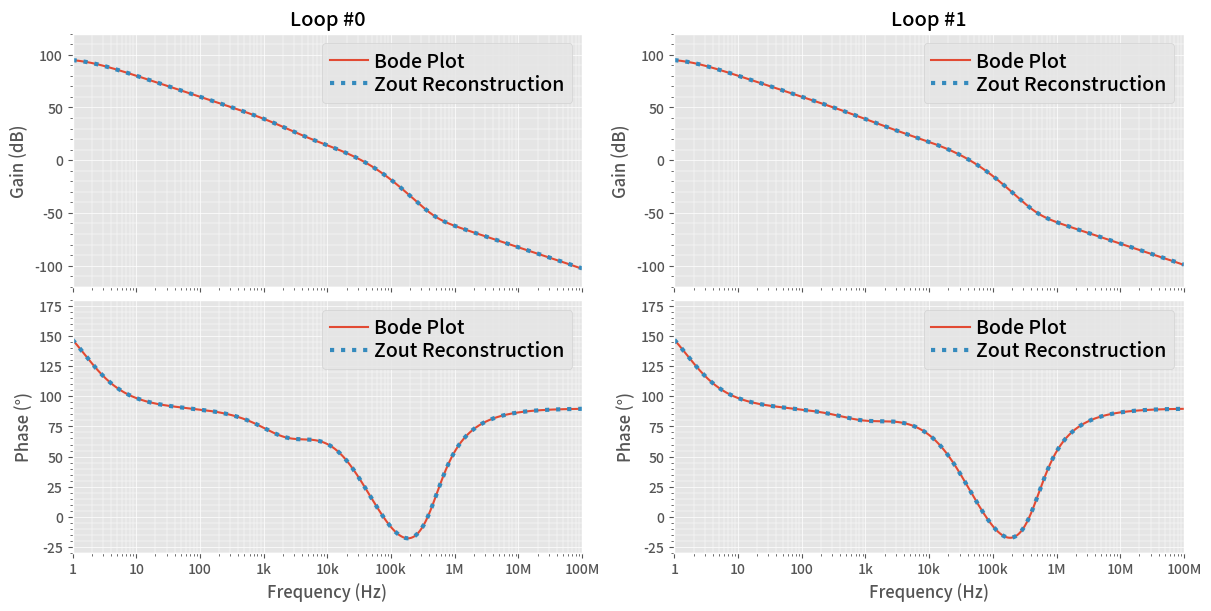

In [4]:
# Prepare a blank plotting area
fig, ax = plt.subplots(2,2,sharex=True,constrained_layout=True,figsize=(12,6))

for i in [0, 1]:
    df[df.Step == i].plot(ax=ax[0,i], x="Freq",  y="gain", label="Bode Plot")
    df[df.Step == i].plot(ax=ax[0,i], x="Freq",  y="abs(Tzo)", label="Zout Reconstruction", linestyle="dotted", linewidth=3)
    run.PrepFreqGainPlot(ax[0,i], "", "Gain (dB)", [], [-120,120], f'Loop #{i}')
    
    df[df.Step == i].plot(ax=ax[1,i], x="Freq",  y="phase", label="Bode Plot")
    df[df.Step == i].plot(ax=ax[1,i], x="Freq",  y="arg(Tzo)", label="Zout Reconstruction", linestyle="dotted", linewidth=3)
    run.PrepFreqGainPlot(ax[1,i], "Frequency (Hz)", "Phase (°)", "auto", [-30,180], "")

plt.savefig("PltTs0.png", format='png', bbox_inches='tight')

plt.show()
plt.close('all')


Above plotting is "per Loop #".  We plot the same curves per "original Bode" and "Re-construction by Zout".

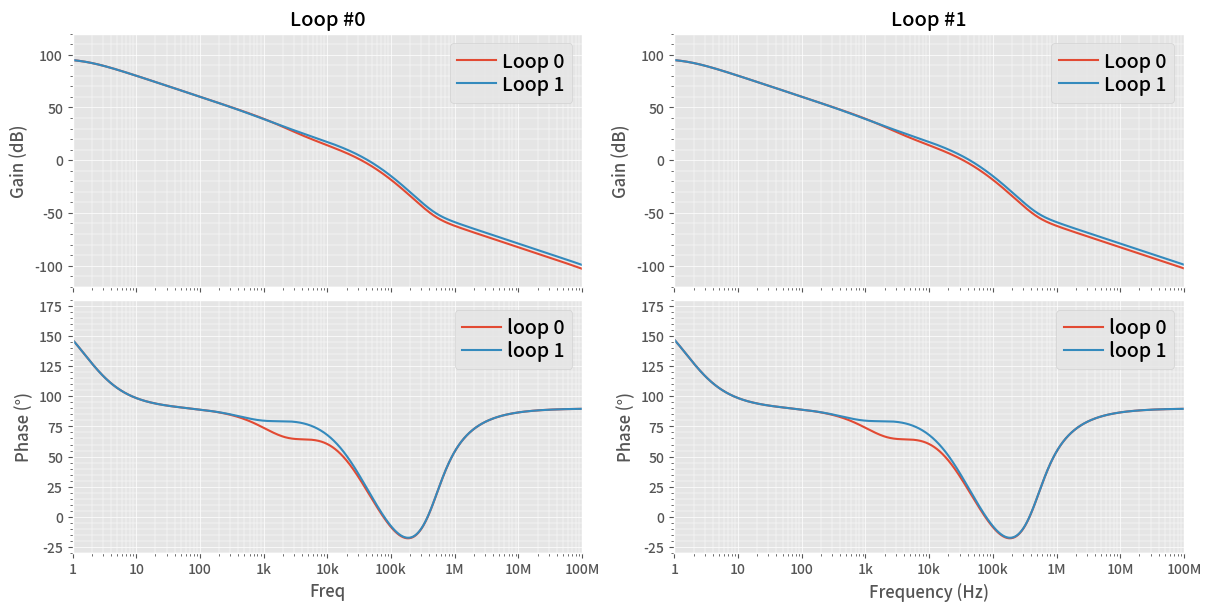

In [5]:
# Prepare a blank plotting area
fig, ax = plt.subplots(2,2,sharex=True,constrained_layout=True,figsize=(12,6))

ax[0,0].set_title('Bode Plot', fontsize=14)
ax[0,1].set_title('Zout Reconstruction', fontsize=14)

for i in [0, 1]:
    df[df.Step == i].plot(ax=ax[0,0], x="Freq",  y="gain", label=f"Loop {i}")
    df[df.Step == i].plot(ax=ax[0,1], x="Freq",  y="abs(Tzo)", label=f"Loop {i}")
    run.PrepFreqGainPlot(ax[0,i], "", "Gain (dB)", [], [-120,120], f'Loop #{i}')

    df[df.Step == i].plot(ax=ax[1,0], x="Freq",  y="phase", label=f"loop {i}")
    df[df.Step == i].plot(ax=ax[1,1], x="Freq",  y="arg(Tzo)", label=f"loop {i}")
    run.PrepFreqGainPlot(ax[1,i], "Frequency (Hz)", "Phase (°)", "auto", [-30,180], "")

plt.savefig("PltTs1.png", format='png', bbox_inches='tight')

plt.show()
plt.close('all')


# 4.1 Simple-Math Version

      Step          Freq           dZo
0      0.0  1.000000e+00  9.494426e+01
1      0.0  1.009035e+00  9.492094e+01
2      0.0  1.018152e+00  9.489732e+01
3      0.0  1.027351e+00  9.487341e+01
4      0.0  1.036633e+00  9.484920e+01
...    ...           ...           ...
4093   1.0  9.646616e+07 -6.657570e-07
4094   1.0  9.733774e+07 -6.549778e-07
4095   1.0  9.821719e+07 -6.443908e-07
4096   1.0  9.910459e+07 -6.339926e-07
4097   1.0  1.000000e+08 -6.237797e-07

[4098 rows x 3 columns]


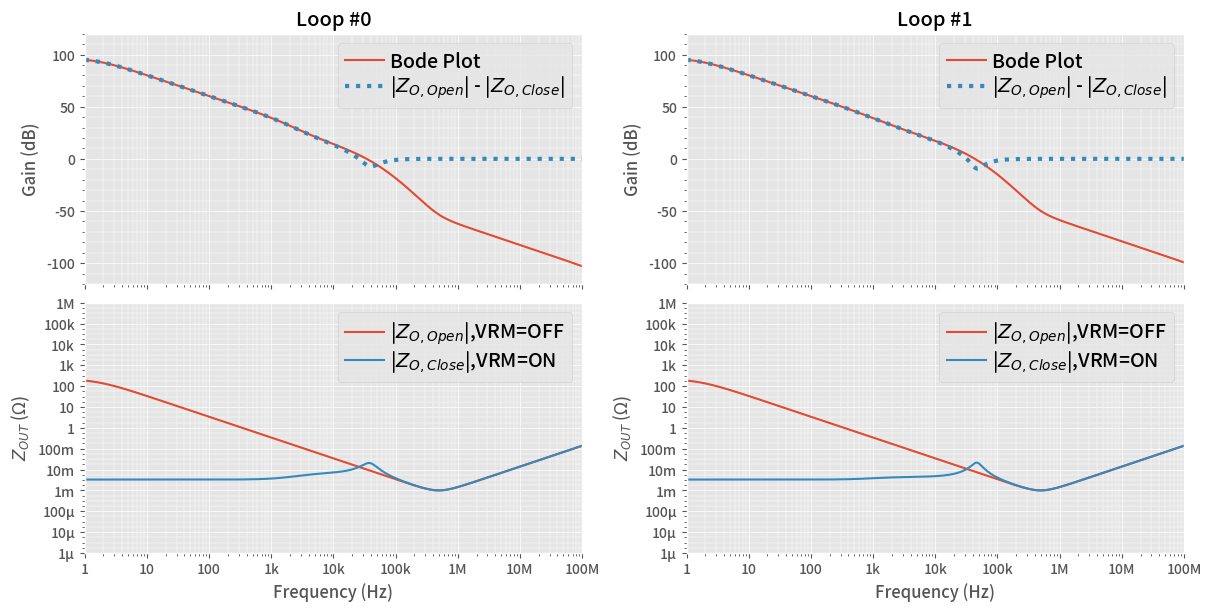

In [6]:

df00 = df.loc[:,["Step","Freq","abs(Zoo)"]].rename(columns = {"abs(Zoo)": "dZo"}) - df.loc[:,["Step","Freq","abs(Zoc)"]].rename(columns={"abs(Zoc)": "dZo"})
#print(df.loc[:,["abs(Zoo)"]].rename(columns = {"abs(Zoo)": "a"}))
#print(df[df.Step == 0].loc[:,["abs(Zoc)"]].rename(columns={"abs(Zoc)": "a"})
df00["Freq"] = df.loc[:,"Freq"]
df00["Step"] = df.loc[:,"Step"]
print(df00)
# Prepare a blank plotting area
fig, ax = plt.subplots(2,2,sharex=True,constrained_layout=True,figsize=(12,6))

for i in [0, 1]:
#if 0:
    df[df.Step == i].plot(ax=ax[0,i], x="Freq",  y="gain", label="Bode Plot")
    df00[df00.Step == i].plot(ax=ax[0,i], x="Freq",  y="dZo", label=r"|$Z_{O,Open}$| - |$Z_{O,Close}$|", linestyle="dotted", linewidth=3)
    run.PrepFreqGainPlot(ax[0,i], "", "Gain (dB)", [], [-120,120], f'Loop #{i}')

    df[df.Step == i].plot(ax=ax[1,i], x="Freq",  y="abs(Zoo)", label=r"|$Z_{O,Open}$|,VRM=OFF")
    df[df.Step == i].plot(ax=ax[1,i], x="Freq",  y="abs(Zoc)", label=r"|$Z_{O,Close}$|,VRM=ON")
    run.PrepFreqImpePlot(ax[1,i], "Frequency (Hz)", r"$Z_{OUT}$ ($\Omega$)", "auto", [-120,120], "")

plt.savefig("PltTs2.png", format='png', bbox_inches='tight')

plt.show()
plt.close('all')
